<a href="https://www.kaggle.com/code/aisuko/deconstruct-basic-diffusers-pipeline?scriptVersionId=135133527" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Overview
In the example above, the pipline contains a [UNe2DModel](https://huggingface.co/docs/diffusers/v0.17.1/en/api/models#diffusers.UNet2DModel) model and a [DDPMScheduler](https://huggingface.co/docs/diffusers/v0.17.1/en/api/schedulers/ddpm#diffusers.DDPMScheduler). The pipline [denoises an image](https://app.gitbook.com/o/V2I20JSLdpI7S91XG35d/s/qm1WfU7McQ1hgBrDXi90/ai-techniques/stable-diffusion/denoising-strength) by taking random noise the size of the derired output and passing it through the model several times. Ar each timestep, the mkodel predicts the noise residual and the scheduler uses it to [predict](https://app.gitbook.com/o/V2I20JSLdpI7S91XG35d/s/qm1WfU7McQ1hgBrDXi90/ai-techniques/stable-diffusion/diffusion-in-image#noise-predictor) a less noisy image. The pipline repaetas this process until it reaches the end of the specified number of inference steps.

## Installing the requirements

In [1]:
!pip install diffusers["torch","flax"] transformers --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 84.1 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.30.1
    Uninstalling transformers-4.30.1:
      Successfully uninstalled transformers-4.30.1


## The entire denoising process

In [2]:
# check the paltform, Apple Silicon or Linux
import os, platform

torch_device='cpu'

if 'kaggle' in os.environ.get('KAGGLE_URL_BASE','localhost'):
    torch_device = 'cuda'
else:
    torch_device = 'mps' if platform.system() == 'Darwin' else 'cpu'

### Checking the backend of pytorch

In [3]:
torch_device

'cuda'

## 1.Load the model and scheduler

In [4]:
from diffusers import DDPMScheduler, UNet2DModel
# load the model and scheduler
scheduler = DDPMScheduler.from_pretrained('google/ddpm-cat-256')
model = UNet2DModel.from_pretrained('google/ddpm-cat-256').to(torch_device)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

0it [00:00, ?it/s]

***Setting the scheduler timtsteps*** creates a tensor with evenly spaced elements in it. 25 in this case. Each element corresponds to a timestep in at which the model denoises an image. When you create the denoising loop later, you will iterate over this tensor to denoise an image:

In [5]:
# Set the number of timesteps to run the denoising process
scheduler.set_timesteps(25)
scheduler.timesteps

tensor([960, 920, 880, 840, 800, 760, 720, 680, 640, 600, 560, 520, 480, 440,
        400, 360, 320, 280, 240, 200, 160, 120,  80,  40,   0])

## 2.Create some random noise with the same shape as the desited output

In [6]:
import torch
sample_size =model.config.sample_size
# If here use Apple Silicon, please use to("mps")
noise = torch.randn((1, 3, sample_size, sample_size)).to(torch_device)

## 3.A loop to iterate over the timesteps

At each timestep, the model does a UNet2DModel.forward() pass and returns the noisy residual. The scheduler's step() method takes the noisy residual, timestep, and input and it predicts the image at the previous timestep. This output becomes the next input to the model in the denoising loop, and it'll repeat until it reaches the end of the timesteps array.

In [7]:
from tqdm import tqdm
input = noise
for t in tqdm(scheduler.timesteps):
    with torch.no_grad():
        noisy_residual=model(input, t).sample
    previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
    input = previous_noisy_sample

100%|██████████| 25/25 [00:06<00:00,  3.88it/s]


## 4.Convert the denoised output into an image

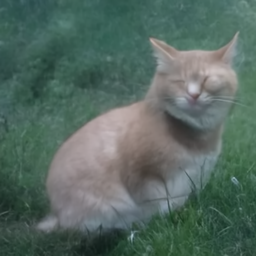

In [8]:
from PIL import Image
import numpy as np

image = (input /2 + 0.5).clamp(0, 1)
image=image.cpu().permute(0, 2, 3, 1).numpy()[0]
image = Image.fromarray((image * 255).round().astype(np.uint8))
image

### Conclusion
In summary, we `initialize the necessary component`s, and `set` the `number of timesteps` to `create a timestep array`. The `timestep array` is used in the `denoising loop`, and for `each element in this array`, the model `predicts a less noisy image`. The `denoising loop` iterates over the timestep's, and at each timestep, it outputs `a noist residual` and `the scheduler` uses it to `predict a less noisy image` at the `previous timestep`. The process is `repated` until you `reach the end of the timestep array`.